# Exploratory Data Analysis of the 2019 Kaggle ML & DS Survey

As a part of the Course: [Data Science Nanodegree](https://www.udacity.com/course/data-scientist-nanodegree--nd025), an analysis of the 2019 Kaggle ML & DS Survey data will be conducted.

The data can be found on Kaggle [here](https://www.kaggle.com/c/kaggle-survey-2019/data). 



# CRISP-DM Process (Cross Industry Process for Data Mining)
The CRISP-DM process is as follows:
1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Data Modelling
5. Evaluate the Results
6. Deploy

## 1. Business Understanding
The purpose of this analysis is to provide newcomers a brief overview of the data science industry. We will be using a mix of descriptive and machine learning to help answer their questions. 

For this dataset, we will be asking 7 main questions: 
1. What is the breakdown of degree type for each profession? - Descriptive statistics
2. What are the most popular platforms for learning among the different occupations? - Descriptive statistics
3. What are the programs / softwares are most used among the different occupations? - Descriptive statistics
4. What programming languages do each of the professions recommend to learn for a newcomer? - Descriptive statistics
5. What are the current languages used for each occupation? Do they differ significantly from what they recommend newcomers to use? - Descriptive statistics
6. What are the salaries for each occupation? - Descriptive statistics
7. Using a simple linear model, what variables are the most significant in predicting salary? - Inferential statistics / machine learning

## 2. Data Understanding

### A brief summary of the data
19, 717 survey respondents were gathered from over 171 different countries. If a country or territory received less than 50 respondents, they were categorized as “Others”.

The users were surveyed based on their experiences. More experienced users were exposed to more questions as compared to their fresh counterparts.  

It should be noted that the emphasis of the analysis would be on the MCQ options. Options manually keyed in by the respondents will be dropped. A seperate text-based analysis can be done on these terms.

## 3. Data Preparation

The dataset consists of a total of 34 questions. As some of the later questions were only asked for the more experienced users (eg ```Which automated machine learning tools do you use?```), we will only focus on the first 19 questions.


In [1]:
# Import libraries
import IPython
import jovian
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings
%matplotlib inline

In [2]:
# Import dataset
survey_df = pd.read_csv('multiple_choice_responses.csv', skiprows = 1)

# We are only interested until qn 19
survey_df = survey_df.loc[:, 'What is your age (# years)?' : 'What programming language would you recommend an aspiring data scientist to learn first? - Other - Text']

Let's see how the raw data looks like

In [3]:
survey_df.head()

,What is your age (# years)?,What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe - Text,In which country do you currently reside?,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?,Select the title most similar to your current role (or most recent title if retired): - Selected Choice,Select the title most similar to your current role (or most recent title if retired): - Other - Text,What is the size of the company where you are employed?,Approximately how many individuals are responsible for data science workloads at your place of business?,Does your current employer incorporate machine learning methods into their business?,...,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Java,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Javascript,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - TypeScript,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Bash,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - MATLAB,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - None,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Other,What programming languages do you use on a regular basis? (Select all that apply) - Other - Text,What programming language would you recommend an aspiring data scientist to learn first? - Selected Choice,What programming language would you recommend an aspiring data scientist to learn first? - Other - Text
0,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,I do not know,...,Java,Javascript,NaN,NaN,MATLAB,NaN,NaN,-1,Python,-1
1,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,-1
2,55-59,Female,-1,Germany,Professional degree,NaN,-1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,-1
3,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,I do not know,...,NaN,NaN,NaN,Bash,NaN,NaN,NaN,-1,Python,-1
4,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,No (we do not use ML methods),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,Python,-1


Majority of the questions have multiple options / columns associated.

We define a helper function below, which helps in extracting the relevant columns.

### Defining a function to handle a single MRQ question

In [4]:
# Define a function to handle a single MRQ (Multiple Response Question)
def parse_mrq_qn(question_string, survey_df):
    '''
    INPUT 
        - question_string - string - the question which the user is interested in
        - survey_df - Pandas dataframe - dataframe containing the survey data
    OUTPUT 
        - question_df - dataframe containing columns only matching the specified question_string
    '''
    
    # Find all columns matching the question string
    question_columns = [col for col in survey_df.columns if question_string in col]
    
    # Subset the dataframe
    question_df = survey_df[question_columns].copy()
    
    # Extract options and populate dict to be used for renaming columns
    options = []
    renamed_dictionary = {}
    for col in question_df.columns:
        dash_index = col.rfind("-")
        option = col[dash_index + 2 :]
        options.append(option)
        renamed_dictionary[col] = option
        
    # Rename the columns
    question_df = question_df.rename(columns = renamed_dictionary, errors = "raise")
    
    # Change NaNs to False
    question_df = question_df.fillna(False)

    # Change all filled valid entries to True
    colnames = question_df.columns
    for index, row in question_df.iterrows():
        for col in colnames:
            cell_value = row[col]
        
            if str(cell_value) == 'False':
                value = False
            else:
                value = True
        
            question_df.loc[index, col] = value
    
    return question_df

### Cleaning salary values

In [5]:
survey_df['What is your current yearly compensation (approximate $USD)?'].head()

0      30,000-39,999
1        5,000-7,499
2                NaN
3    250,000-299,999
4        4,000-4,999
Name: What is your current yearly compensation (approximate $USD)?, dtype: object

As the salary values are either NaNs or a range, we need to clean the salary column. We will be assigning each salary value the midpoint of both endpoints. For example, if the salary option chosen is 5,000-7,499 , the quantitative value of $6,249.50 will be assigned. 

In [6]:
# Clean up the salary column. Add a new column which is the mid point of the ranges
salary_column = 'What is your current yearly compensation (approximate $USD)?'
survey_df['salary_cleaned'] = np.NaN

for index, row in survey_df.iterrows():
    salary_string = row[salary_column]
    salary_string = str(salary_string).replace("$", "")
    
    if (len(salary_string.split("-")) == 2):
        
        start_salary = float(salary_string.split("-")[0].replace(",", ""))
        end_salary = float(salary_string.split("-")[1].replace(",", ""))
        mid_point_salary = (start_salary + end_salary) / 2.0
        
    elif salary_string == "> 500,000":
        
        mid_point_salary = 500000
        
    else:
        
        mid_point_salary = np.NaN
        
    survey_df.loc[index, 'salary_cleaned'] = mid_point_salary

### Cleaning age values
Similar with salary, the age option is also specified as a range. Hence, this must be converted to a quantitative value. 

In [7]:
# Clean up the ages column. Add a new column which is the mid point of the age ranges
age_column = 'What is your age (# years)?'
survey_df['age_cleaned'] = np.NaN

for index, row in survey_df.iterrows():
    age_option = row[age_column]
    ages = age_option.split('-')
    
    if (ages[0] == '70+'):
        mid_point = 72.5
    else: 
        mid_point = ( float(ages[0]) + float(ages[1]) ) / 2
    survey_df.loc[index, 'age_cleaned'] = mid_point

### Viewing unique questions
We see what unique questions we have in our dataset.

In [8]:
# View the questions from the survey
unique_qns = []
for col in survey_df.columns:
    question_mark_index = col.find('?')
    question = col[0 : question_mark_index + 1]
    
    if question_mark_index == -1:
        colon_index = col.find(':')
        if colon_index != -1:
            question = col[0 : colon_index]
        
    if question not in unique_qns and len(question) > 0:
        unique_qns.append(question)
        
print('Survey Questions are: ')
for i in range(len(unique_qns)):
    print(str(i+1) + ". " + unique_qns[i])

Survey Questions are: 
1. What is your age (# years)?
2. What is your gender?
3. In which country do you currently reside?
4. What is the highest level of formal education that you have attained or plan to attain within the next 2 years?
5. Select the title most similar to your current role (or most recent title if retired)
6. What is the size of the company where you are employed?
7. Approximately how many individuals are responsible for data science workloads at your place of business?
8. Does your current employer incorporate machine learning methods into their business?
9. Select any activities that make up an important part of your role at work
10. What is your current yearly compensation (approximate $USD)?
11. Approximately how much money have you spent on machine learning and/or cloud computing products at your work in the past 5 years?
12. Who/what are your favorite media sources that report on data science topics?
13. On which platforms have you begun or completed data scienc

## Exploratory Analysis and Visualization

In [9]:
print("The dataset has a total of " + str(len(survey_df) ) + " respondents." )

The dataset has a total of 19717 respondents.


### Let's see the demographics of the respondents.

#### What is the age distribution of the respondents?

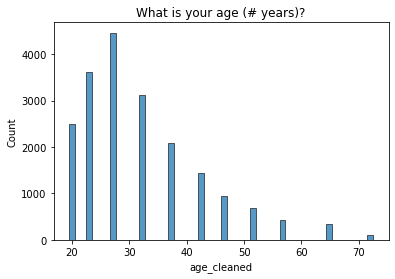

In [10]:
question_string = 'What is your age (# years)?'
plt.title(question_string)
sns.histplot(survey_df['age_cleaned']);

From the above plot, a large majority of the respondents are in the range 20 - 40. After 40, the counts slowly taper off. This shows that Data Science is a relatively new industry, appealing more to the youth-middle aged workers.

#### What is the gender split for the respondents?

In [11]:
question_string = 'What is your gender? - Selected Choice'
question_df = survey_df[[question_string]]

question_df[question_string].value_counts()

Male                       16138
Female                      3212
Prefer not to say            318
Prefer to self-describe       49
Name: What is your gender? - Selected Choice, dtype: int64

We drop rows that are not male and female. Subsequently, we visualize the gender distribution using a pie chart

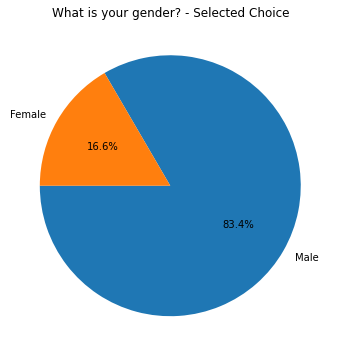

In [12]:
gender_terms = ['Male', 'Female']
question_df = question_df[question_df[question_string].str.contains('|'.join(gender_terms))]

gender_counts = question_df[question_string].value_counts()
plt.figure(figsize=(12,6))
plt.title(question_string)
plt.pie(gender_counts, labels = gender_counts.index, autopct='%1.1f%%', startangle=180);

Unfortunately, the female gender is grossly misrepresented. However, this is much better than the gender ratio for the 2020 Stack Overflow Developer Survey, which has a female:male split of 8.0% : 91.5%. See [here](https://insights.stackoverflow.com/survey/2020#developer-profile-gender-all-respondents2).

#### Which countries do the respondents reside in?

Although the data came from more than 170 countries, only countries with more than 50 entries were considered.
This left a total of 59 countries


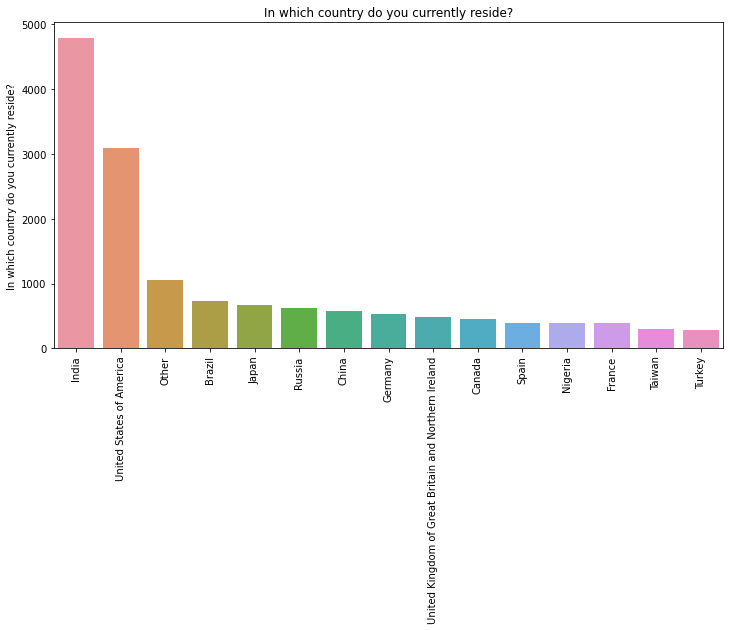

In [13]:
question_string = 'In which country do you currently reside?'
question_df = survey_df[[question_string]]
print("Although the data came from more than 170 countries, only countries with more than 50 entries were considered.\nThis left a total of " + str(len(question_df[question_string].unique())) + " countries")
top_countries = question_df[question_string].value_counts().head(15)

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
plt.title(question_string)
sns.barplot(top_countries.index, top_countries);

India and the United States make up the largest 2 countries. 

The full data is in the table below for the reader to see. Can you find your country inside?

In [14]:
pd.reset_option('max_rows')
(question_df[question_string].value_counts().to_frame())

,In which country do you currently reside?
India,4786
United States of America,3085
Other,1054
Brazil,728
Japan,673
Russia,626
China,574
Germany,531
United Kingdom of Great Britain and Northern Ireland,482
Canada,450


#### What level of education have the respondents attained?


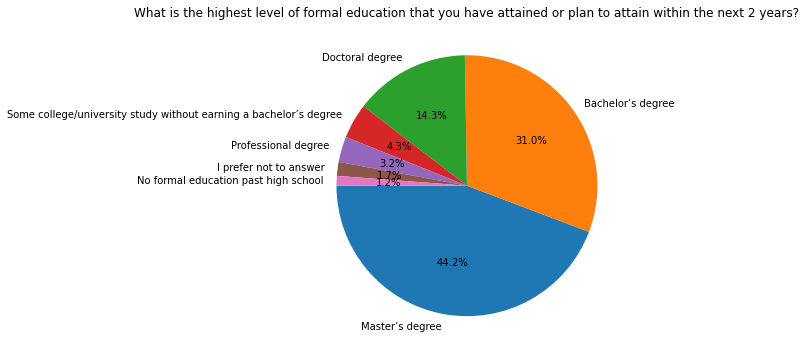

In [15]:
question_string = 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?'
question_df = survey_df[[question_string]]

education_counts = question_df[question_string].value_counts()
plt.figure(figsize=(12,6))
plt.title(question_string)
plt.pie(education_counts, labels = education_counts.index, autopct='%1.1f%%', startangle=180);

It appears that to get into Data Science, an academic degree (Bachelor, Masters or Doctoral) is preferred. Interestingly, graduate degrees (Masters and Doctoral) make up a total of 58.5% of the total survey respondents. This means that majority of the respondents have at least a post-graduate degree.

Of course, this data only pertains to users of Kaggle. Perhaps the majority of Bachelor holders are occupying software engineering positions that are not related to data roles. 

## Answering Questions that require Descriptive Statistics

These are the 6 areas we will be focusing on.
1. What is the breakdown of degree type for each profession?
2. What are the most popular platforms for learning among the different occupations?
3. What are the programs / softwares are most used among the different occupations?
4. What programming languages do each of the professions recommend to learn for a newcomer?
5. What are the current languages used for each occupation? Do they differ significantly from what they recommend newcomers to use?
6. What are the salaries for each occupation?

### 1. What is the breakdown of degree type for each profession?

These are the options available for the respondents to choose for profession: 

- Software Engineer
- Data Scientist
- Research Scientist
- Statistician
- Product/Project Manager
- Data Analyst
- Business Analyst
- Data Engineer
- DBA/Database Engineer
- Student

For the professional backgrounds, ```Research Scientist``` will be merged with ```Data Scientist```. ```Data Engineer``` will be merged with ```DBA/Database Engineer```. ```Data Analyst``` will be merged with ```Business Analyst```.

In [16]:
# Extract the data for each occupation type
occupation_column = 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice'

analyst = ['Business Analyst', 'Data Analyst']
software_eng = ['Software Engineer']
scientist = ['Data Scientist', 'Research Scientist']
statistican = ['Statistician']
manager = ['Product/Project Manager']
data_eng = ['Data Engineer', 'DBA/Database Engineer']

# Filter by degree first
degree_terms = ['Doctoral', 'Bach', 'Master']
education_column = 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?'
degree_df = survey_df[survey_df[education_column].notna()]
degree_df = degree_df[degree_df[education_column].str.contains('|'.join(degree_terms))]

# Further split the degree df into the various occupations
analyst_df = degree_df[degree_df[occupation_column].isin(analyst)]
software_eng_df = degree_df[degree_df[occupation_column].isin(software_eng)]
scientist_df = degree_df[degree_df[occupation_column].isin(scientist)]
statistican_df = degree_df[degree_df[occupation_column].isin(statistican)]
manager_df = degree_df[degree_df[occupation_column].isin(manager)]
data_eng_df = degree_df[degree_df[occupation_column].isin(data_eng)]

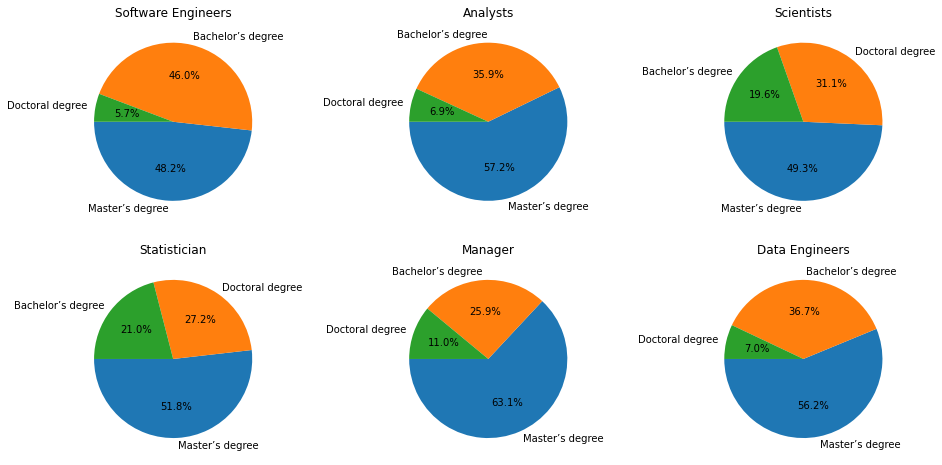

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

# Plot for software eng
df = software_eng_df[[education_column]]
counts = df[education_column].value_counts()
axes[0,0].set_title("Software Engineers")
axes[0,0].pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

# Plot for analyst
question_df = analyst_df[[education_column]]
counts = question_df[education_column].value_counts()
axes[0,1].set_title("Analysts")
axes[0,1].pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

# Plot for scientist
question_df = scientist_df[[education_column]]
counts = question_df[education_column].value_counts()
axes[0,2].set_title("Scientists")
axes[0,2].pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

# Plot for Statistician
question_df = statistican_df[[education_column]]
counts = question_df[education_column].value_counts()
axes[1,0].set_title("Statistician")
axes[1,0].pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

# Plot for manager
question_df = manager_df[[education_column]]
counts = question_df[education_column].value_counts()
axes[1,1].set_title("Manager")
axes[1,1].pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

# Plot for data eng
question_df = data_eng_df[[education_column]]
counts = question_df[education_column].value_counts()
axes[1,2].set_title("Data Engineers")
axes[1,2].pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

From the above plot, we can observe that PhDs tend to gravitate to the Statistician or Scientist roles. Bachelor degree holders are usually occupying the software engineer, data engineer or analyst roles. Masters degree holders appear to be evenly spread and the majority of each occupation. 

### 2. What are the most popular learning platforms among the different occupations?
Perhaps some occupations like software enginners prefer Udemy while analysts prefer Coursera? Let's find out. We will visualize the top 5 most popular platforms for each profession.

In [18]:
# Extract the relevant dataframes
question_string = 'On which platforms have you begun or completed data science courses?'

overall_professions_platforms = parse_mrq_qn(question_string, survey_df)
overall_professions_platforms = overall_professions_platforms.drop(columns=['Text']) 

analyst_platforms = parse_mrq_qn(question_string, analyst_df)
analyst_platforms = analyst_platforms.drop(columns=['Text']) 

software_eng_platforms = parse_mrq_qn(question_string, software_eng_df)
software_eng_platforms = software_eng_platforms.drop(columns=['Text'])

scientist_platforms = parse_mrq_qn(question_string, scientist_df)
scientist_platforms = scientist_platforms.drop(columns=['Text'])

statistician_platforms = parse_mrq_qn(question_string, statistican_df)
statistician_platforms = statistician_platforms.drop(columns=['Text'])

manager_platforms = parse_mrq_qn(question_string, manager_df)
manager_platforms = manager_platforms.drop(columns=['Text'])

data_eng_platforms = parse_mrq_qn(question_string, data_eng_df)
data_eng_platforms = data_eng_platforms.drop(columns=['Text'])

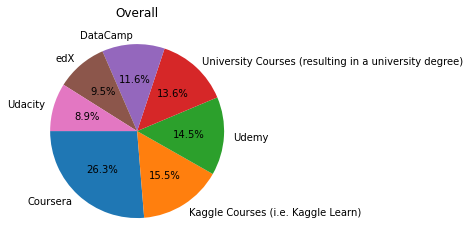

In [19]:
# Plot for the overall platform
overall_platform_counts = overall_professions_platforms.sum().sort_values(ascending=False).head(7)
plt.title("Overall")
plt.pie(overall_platform_counts, labels = overall_platform_counts.index, autopct='%1.1f%%', startangle=180);

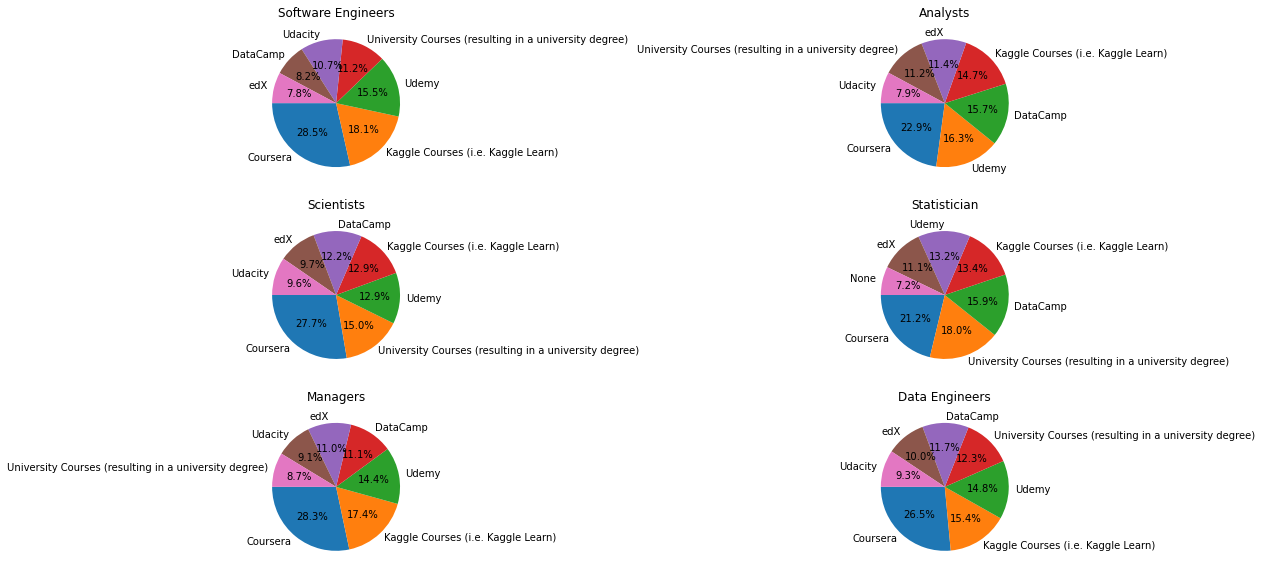

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(20, 10))

# Plot for software eng
software_eng_platform_counts = software_eng_platforms.sum().sort_values(ascending=False).head(7)
axes[0,0].set_title("Software Engineers")
axes[0,0].pie(software_eng_platform_counts, labels = software_eng_platform_counts.index, autopct='%1.1f%%', startangle=180);

# Plot for analyst
analyst_platforms_counts = analyst_platforms.sum().sort_values(ascending=False).head(7)
axes[0,1].set_title("Analysts")
axes[0,1].pie(analyst_platforms_counts, labels = analyst_platforms_counts.index, autopct='%1.1f%%', startangle=180);

# Plot for scientist
scientist_platforms_counts = scientist_platforms.sum().sort_values(ascending=False).head(7)
axes[1,0].set_title("Scientists")
axes[1,0].pie(scientist_platforms_counts, labels = scientist_platforms_counts.index, autopct='%1.1f%%', startangle=180);

# Plot for Statistician
statistician_platforms_counts = statistician_platforms.sum().sort_values(ascending=False).head(7)
axes[1,1].set_title("Statistician")
axes[1,1].pie(statistician_platforms_counts, labels = statistician_platforms_counts.index, autopct='%1.1f%%', startangle=180);

# Plot for manager
manager_platforms_counts = manager_platforms.sum().sort_values(ascending=False).head(7)
axes[2,0].set_title("Managers")
axes[2,0].pie(manager_platforms_counts, labels = manager_platforms_counts.index, autopct='%1.1f%%', startangle=180);

# Plot for data eng
data_eng_platforms_counts = data_eng_platforms.sum().sort_values(ascending=False).head(7)
axes[2,1].set_title("Data Engineers")
axes[2,1].pie(data_eng_platforms_counts, labels = data_eng_platforms_counts.index, autopct='%1.1f%%', startangle=180);

For all the professions, Coursera comes as a clear winner. 

For Statisticians, their 2nd source is from their own university courses. This is similar for Scientists. Perhaps there is a correlation between the skill sets needed for both jobs.

Udacity only makes an appeareance among Software Engineers. This seems to be the case as their courses are usually geared for Software Development. 

It is also interesting to note that for Managers and Analysts, their source of knowledge did not come from their university education. Perhaps this shows that for these roles, the respondents had came from other non-related disciplines.

Kaggle courses rank highly among all 5 occupations. There are 2 takeaways from this. Firstly, Kaggle could be seen as the "go-to" platform for all Data Science related competitions and datasets. Secondly, there could be survey bias as the survey was conducted on the Kaggle platform after all.

Udacity makes up a small percentage for each occupation, with the exception for Statisticians. 

### 3. What is the most used software among the different occupations?
Another important question for someone trying to break into a DS role is what software / technology is used. This will help greatly in deciding what to study for and how to prepare for interview.

In the survey, the respondents were asked what software they primarily use. These are the possible options:
- Basic statistical software (Microsoft Excel, Google Sheets, etc.
- Advanced statistical software (SPSS, SAS, etc.) 
- Business intelligence software (Salesforce, Tableau, Spotfire, etc.)
- Local development environments (RStudio, JupyterLab, etc.)
- Cloud-based data software & APIs (AWS, GCP, Azure, etc.)
- Other

In [21]:
# Extract relevant dataframes
question_string ='What is the primary tool that you use at work or school to analyze data? (Include text response) - Selected Choice'
overall_professions_softwares = survey_df[[question_string]].dropna(subset = [question_string])
analyst_softwares = analyst_df[[question_string]].dropna(subset = [question_string])
software_eng_softwares = software_eng_df[[question_string]].dropna(subset = [question_string])
manager_softwares = manager_df[[question_string]].dropna(subset = [question_string])
data_eng_softwares = data_eng_df[[question_string]].dropna(subset = [question_string])
scientist_softwares = scientist_df[[question_string]].dropna(subset = [question_string])
statistician_softwares = statistican_df[[question_string]].dropna(subset = [question_string])

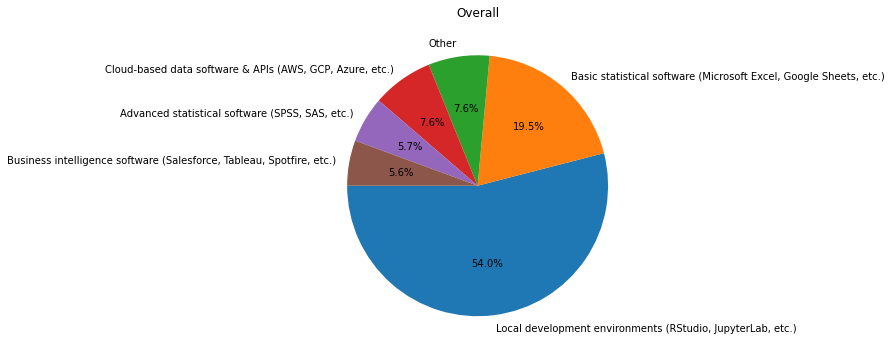

In [22]:
counts = overall_professions_softwares[question_string].value_counts()
counts = counts[counts > 10]
plt.figure(figsize=(12,6))
plt.title('Overall')
plt.pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

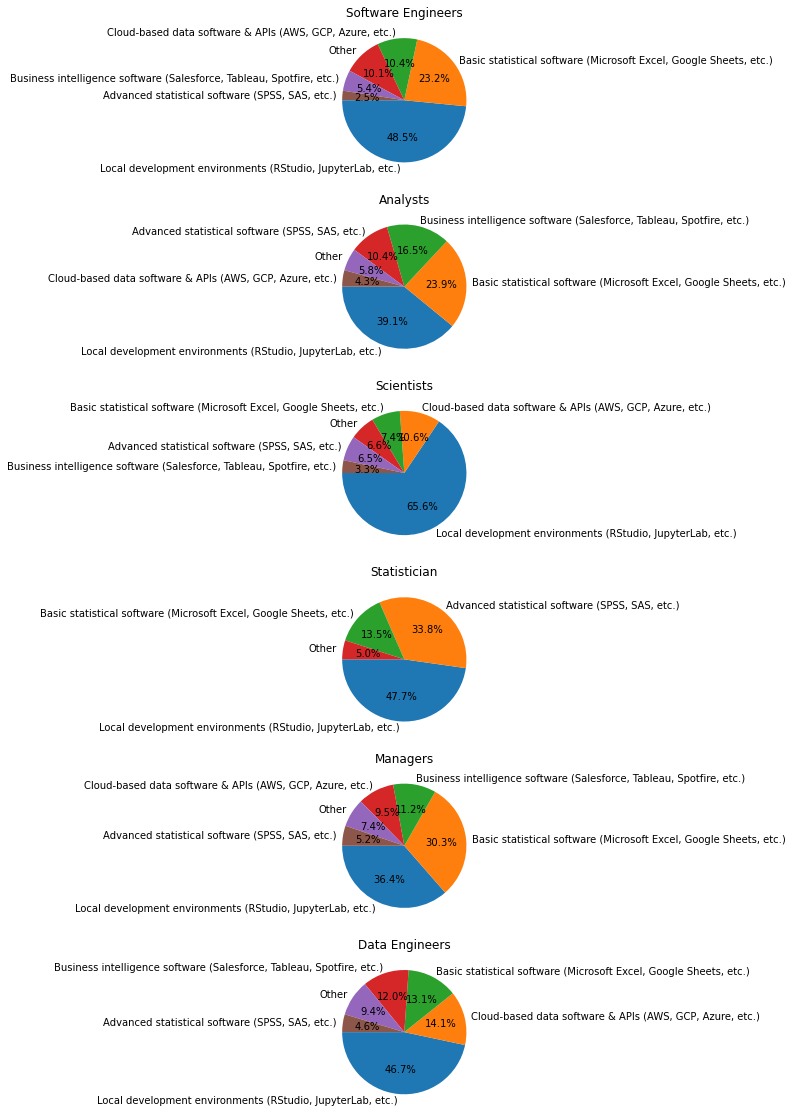

In [23]:
fig, axes = plt.subplots(6, 1, figsize=(16, 20))

# Plot for software eng
counts = software_eng_softwares[question_string].value_counts()
counts = counts[counts > 10]
axes[0].set_title("Software Engineers")
axes[0].pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

# Plot for analyst
counts = analyst_softwares[question_string].value_counts()
counts = counts[counts > 10]
axes[1].set_title("Analysts")
axes[1].pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

# Plot for scientist
counts = scientist_softwares[question_string].value_counts()
counts = counts[counts > 10]
axes[2].set_title("Scientists")
axes[2].pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

# Plot for Statistician
counts = statistician_softwares[question_string].value_counts()
counts = counts[counts > 10]
axes[3].set_title("Statistician")
axes[3].pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

# Plot for manager
counts = manager_softwares[question_string].value_counts()
counts = counts[counts > 10]
axes[4].set_title("Managers")
axes[4].pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

# Plot for data eng
counts = data_eng_softwares[question_string].value_counts()
counts = counts[counts > 10]
axes[5].set_title("Data Engineers")
axes[5].pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

From the above plots, we can observe that for Scientists and Statisticians, a large portion have to primarily use a Local Development Environment. The difference between Scientists and Statisticians are that Statisticians are more focused on the modelling whereas the Scientists have to also be exposed to other software, such as cloud computing. 

Another interesting observation is that for Managers, the majority of them are using softwares (Basic statistical software, BI software, cloud etc) instead of development environments. The same can also be said for the Data Analyst roles. Hence, for a new programmer coming into ML/DS, these are the roles that they should aim for.

For the Data Engineers, Software Engineers, Scientists and Statisticians, a large portion of these roles involve heavy coding (high usage of Development Environments).

Another interesting point is that for Software Engineers, a high 23.2% are primarily using Basic Statistical Software. Perhaps these users are in a software engineer / manager hybrid role? Perhaps as a SCRUM master.

### 4. What programming languages do each of the profession recommend to learn, for a newcomer?
One of the questions asked were what languages would the respondents recommend for newcomers into their profession. 

In the survey, these are the possible options:
- Python
- R
- SQL
- Java
- C
- C++
- MATLAB
- Javascript
- TypeScript
- Bash
- Other

In [24]:
# Extract relevant dataframes
question_string ='What programming language would you recommend an aspiring data scientist to learn first? - Selected Choice'
overall_professions_lang = survey_df[[question_string]].dropna(subset = [question_string])
analyst_lang = analyst_df[[question_string]].dropna(subset = [question_string])
software_eng_lang = software_eng_df[[question_string]].dropna(subset = [question_string])
manager_lang = manager_df[[question_string]].dropna(subset = [question_string])
data_eng_lang = data_eng_df[[question_string]].dropna(subset = [question_string])
scientist_lang = scientist_df[[question_string]].dropna(subset = [question_string])
statistician_lang = statistican_df[[question_string]].dropna(subset = [question_string])

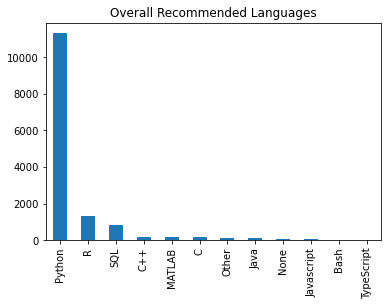

In [25]:
plt.title('Overall Recommended Languages')
overall_professions_lang[question_string].value_counts().plot(kind='bar');

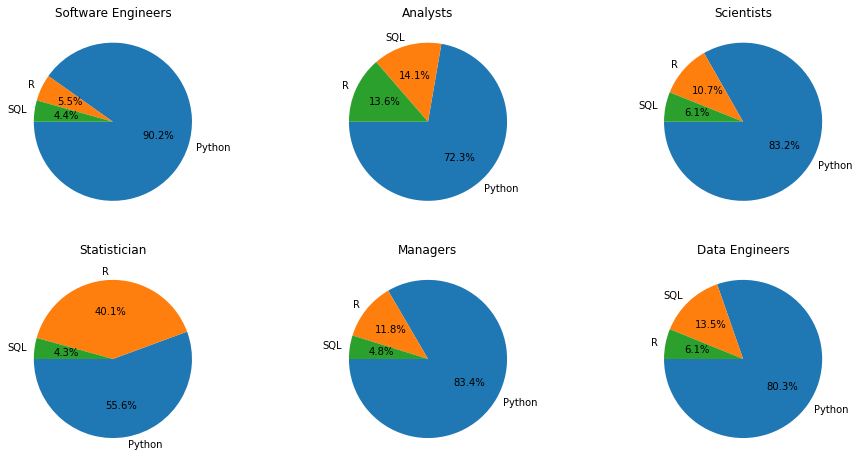

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

# Plot for software eng
counts = software_eng_lang[question_string].value_counts()
counts = counts[counts > (0.03 * sum(counts))] # Only show if slice is more than 3%
axes[0,0].set_title("Software Engineers")
axes[0,0].pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

# Plot for analyst
counts = analyst_lang[question_string].value_counts()
counts = counts[counts > (0.03 * sum(counts))]
axes[0,1].set_title("Analysts")
axes[0,1].pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

# Plot for scientist
counts = scientist_lang[question_string].value_counts()
counts = counts[counts > (0.03 * sum(counts))]
axes[0,2].set_title("Scientists")
axes[0,2].pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

# Plot for Statistician
counts = statistician_lang[question_string].value_counts()
counts = counts[counts > (0.03 * sum(counts))]
axes[1,0].set_title("Statistician")
axes[1,0].pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

# Plot for manager
counts = manager_lang[question_string].value_counts()
counts = counts[counts > (0.03 * sum(counts))]
axes[1,1].set_title("Managers")
axes[1,1].pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

# Plot for data eng
counts = data_eng_lang[question_string].value_counts()
counts = counts[counts > (0.03 * sum(counts))]
axes[1,2].set_title("Data Engineers")
axes[1,2].pie(counts, labels = counts.index, autopct='%1.1f%%', startangle=180);

Across all the occupations, the recommended languages in decreasing order of importance are: Python, SQL, R.
Interesting to note that R has a high weightage for Statisticians. Perhaps this shows that a majority of the statistical libraries are still implemented in R and have not been ported to Python yet.

Another weird observation is that the Software Engineers also recommend the same 3 languages, despite Software Engineers using Java or C++ for their work. 


### 5. What are the current languages used for each occupation? Do they differ significantly from what they recommend newcomers to use?

Similar to question 4, the options available are also the same.


In [27]:
# Extract relevant data
question_string = 'What programming languages do you use on a regular basis?'
overall_current_lang = parse_mrq_qn(question_string, survey_df).drop(columns=['Text', 'None', 'Other'])
overall_current_lang = overall_current_lang.sum().sort_values(ascending=False)
analyst_current_lang = parse_mrq_qn(question_string, analyst_df).drop(columns=['Text', 'None', 'Other'])
analyst_current_lang = analyst_current_lang.sum().sort_values(ascending=False)
software_eng_current_lang = parse_mrq_qn(question_string, software_eng_df).drop(columns=['Text', 'None', 'Other'])
software_eng_current_lang = software_eng_current_lang.sum().sort_values(ascending=False)
scientist_current_lang = parse_mrq_qn(question_string, scientist_df).drop(columns=['Text', 'None', 'Other'])
scientist_current_lang = scientist_current_lang.sum().sort_values(ascending=False)
statistician_current_lang = parse_mrq_qn(question_string, statistican_df).drop(columns=['Text', 'None', 'Other'])
statistician_current_lang = statistician_current_lang.sum().sort_values(ascending=False)
manager_current_lang = parse_mrq_qn(question_string, manager_df).drop(columns=['Text', 'None', 'Other'])
manager_current_lang = manager_current_lang.sum().sort_values(ascending=False)
data_eng_current_lang = parse_mrq_qn(question_string, data_eng_df).drop(columns=['Text', 'None', 'Other'])
data_eng_current_lang = data_eng_current_lang.sum().sort_values(ascending=False)

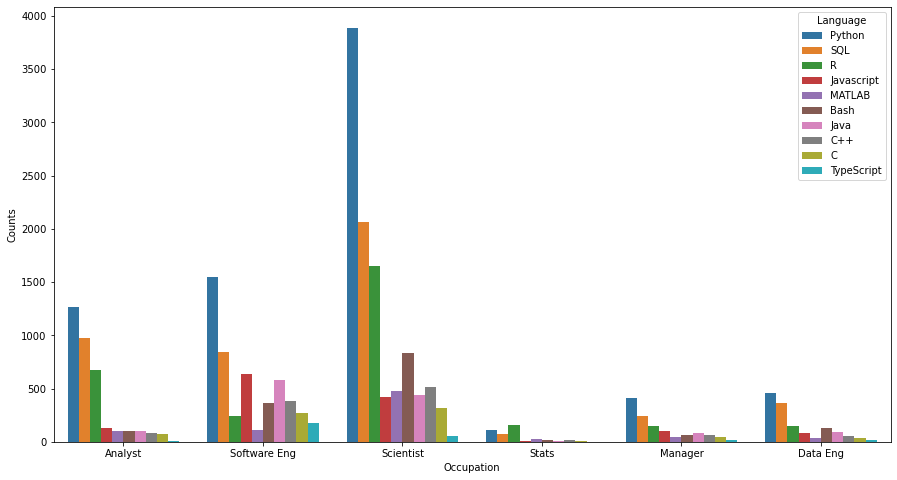

In [28]:
# Combine data into one new dataframe
current_lang_df = pd.DataFrame(columns=['Occupation', 'Language', 'Counts'])
occupation_dict = {'Analyst' : analyst_current_lang, 
                   'Software Eng' : software_eng_current_lang, 'Scientist' : scientist_current_lang, 
                   'Stats' : statistician_current_lang, 'Manager' : manager_current_lang, 
                   'Data Eng' : data_eng_current_lang}

for occupation, series_object in occupation_dict.items():
    for language in series_object.index:
        count = series_object[language]
        new_row = {'Occupation' : occupation, 'Language' : language, 'Counts' : count}
        current_lang_df = current_lang_df.append(new_row, ignore_index=True)
         
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(ax = ax, x = current_lang_df['Occupation'], y = current_lang_df['Counts'], hue = current_lang_df['Language']);

Above plot shows the different counts for each language (different color) for each occupation. Let's equlize their scales.

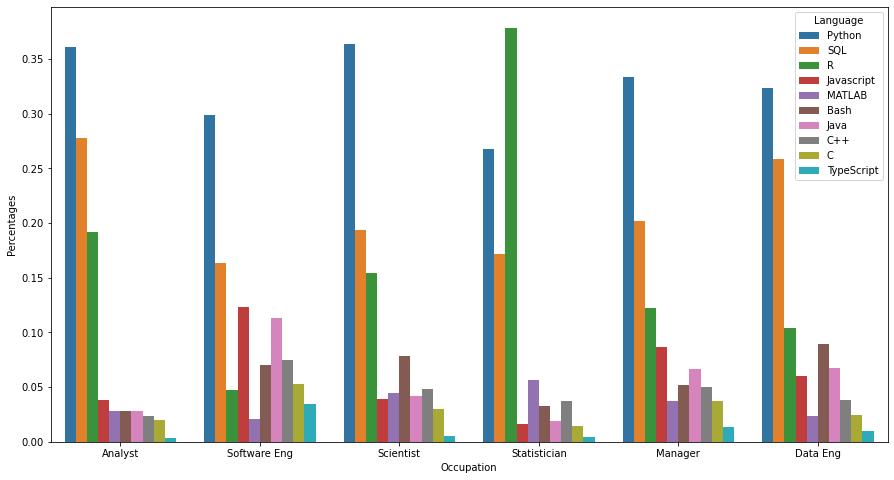

In [29]:
# Combine data into one new dataframe
current_lang_df = pd.DataFrame(columns=['Occupation', 'Language', 'Percentages'])
occupation_dict = {'Analyst' : analyst_current_lang, 
                   'Software Eng' : software_eng_current_lang, 'Scientist' : scientist_current_lang, 
                   'Statistician' : statistician_current_lang, 'Manager' : manager_current_lang, 
                   'Data Eng' : data_eng_current_lang}

for occupation, series_object in occupation_dict.items():
    total_count = sum(series_object)
    for language in series_object.index:
        count = series_object[language] / total_count
        new_row = {'Occupation' : occupation, 'Language' : language, 'Percentages' : count}
        current_lang_df = current_lang_df.append(new_row, ignore_index=True)
         
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(ax = ax, x = current_lang_df['Occupation'], y = current_lang_df['Percentages'], hue = current_lang_df['Language']);

Currently, Python is the most popular langauge except among Statisticians, where the choice is R. 

For the other professions (Analyst, Software Engineers, Data Engineers, Scientist, Managers), their 2nd language is SQL. This show how important learning a database langauge is. It makes sense as most data are stored in structured relational databases. Hence, database knowledge should be a critical skill that anyone in ML/DS should have.

Lastly, the Software Engineers have Java and JavaScript as their 3rd and 4th most used language. Interestingly, this corresponds to the top 5 languages used by Managers and Data Engineers. This makes sense as perhaps closer to production, they would need to interface more with their product APIs.

### Comparison with Recommended Languages for Newcomers
The main difference is among the Software Engineers. They highly recommended learning Python, SQL and R. However, they currently use Java, JavaScript, C++ and Bash more than R. Perhaps this shows a desire for Software Engineers to move on to Data-related roles. Is it for the salary? Let's find out.

### 6. What are the salaries for each occupation?

In [30]:
# Extract the data
salary_column = 'salary_cleaned'
analyst_softwares_salary = analyst_df[[salary_column]].dropna(subset = [salary_column])
software_eng_softwares_salary = software_eng_df[[salary_column]].dropna(subset = [salary_column])
manager_softwares_salary = manager_df[[salary_column]].dropna(subset = [salary_column])
data_eng_softwares_salary = data_eng_df[[salary_column]].dropna(subset = [salary_column])
scientist_softwares_salary = scientist_df[[salary_column]].dropna(subset = [salary_column])
statistician_softwares_salary = statistican_df[[salary_column]].dropna(subset = [salary_column])

# Combine the data into a single dataframe
salary_df = pd.DataFrame(columns=['Occupation', 'Salary'])
salary_dict = {'Analyst' : analyst_softwares_salary, 
                   'Software Eng' : software_eng_softwares_salary, 'Scientist' : scientist_softwares_salary, 
                   'Statistician' : statistician_softwares_salary, 'Manager' : manager_softwares_salary, 
                   'Data Eng' : data_eng_softwares_salary}

for occupation, occupation_salary_df in salary_dict.items():
    for index, row in occupation_salary_df.iterrows():
        salary = row[salary_column]
        new_row = {'Occupation' : occupation, 'Salary' : salary}
        salary_df = salary_df.append(new_row, ignore_index=True)

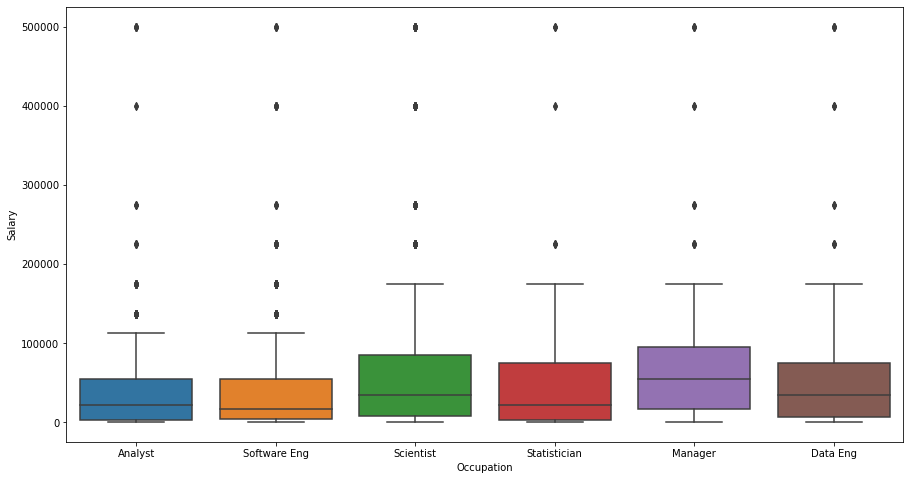

In [31]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(ax = ax, x = salary_df['Occupation'], y = salary_df['Salary']);

As with most income data, they tend to be skewed. This is evident from the large number of outlier observations. Hence, we will narrow down to values below a yearly USD200,000

In [32]:
# Get medians of all occupations
narrow_income = salary_df[salary_df['Salary'] < 200000]
analyst_salary_median = narrow_income[narrow_income['Occupation'] == 'Analyst'].median()[0]
software_eng_salary_median = narrow_income[narrow_income['Occupation'] == 'Software Eng'].median()[0]
scientist_salary_median = narrow_income[narrow_income['Occupation'] == 'Scientist'].median()[0]
statistician_salary_median = narrow_income[narrow_income['Occupation'] == 'Statistician'].median()[0]
manager_salary_median = narrow_income[narrow_income['Occupation'] == 'Manager'].median()[0]
data_eng_salary_median = narrow_income[narrow_income['Occupation'] == 'Data Eng'].median()[0]

Median salaries 
Analyst Median:  17499.5  with sample size:  1868
Software Eng Median:  17499.5  with sample size:  2108
Scientist Median:  34999.5  with sample size:  4613
Statistician Median:  22499.5  with sample size:  248
Manager Median:  44999.5  with sample size:  587
Data Eng Median:  27499.5  with sample size:  604
Salary-occupation data was missing for  9689 entries


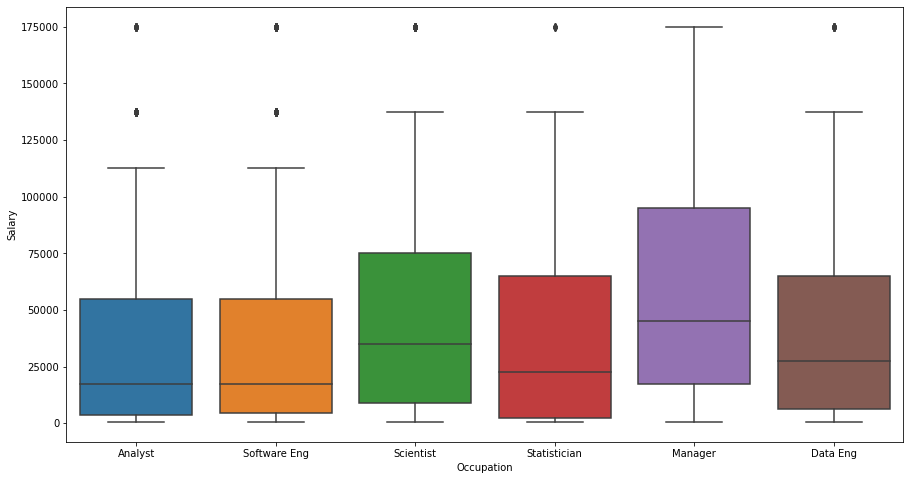

In [33]:
narrow_income = salary_df[salary_df['Salary'] < 200000]
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(ax = ax, x = narrow_income['Occupation'], y = narrow_income['Salary']);
print("Median salaries ")
print("Analyst Median: ",  str(analyst_salary_median) , ' with sample size: ', len(analyst_softwares_salary) )
print("Software Eng Median: ",  str(software_eng_salary_median), ' with sample size: ', len(software_eng_softwares_salary) )
print("Scientist Median: ",  str(scientist_salary_median), ' with sample size: ', len(scientist_softwares_salary) )
print("Statistician Median: ",  str(statistician_salary_median), ' with sample size: ', len(statistician_softwares_salary) )
print("Manager Median: ",  str(manager_salary_median), ' with sample size: ', len(manager_softwares_salary) )
print("Data Eng Median: ",  str(data_eng_salary_median), ' with sample size: ', len(data_eng_softwares_salary) )
num_with_invalid_salaries_or_occupation = len(survey_df) - len(analyst_softwares_salary) - len(software_eng_softwares_salary) - len(scientist_softwares_salary) - len(statistician_softwares_salary) - len(manager_softwares_salary) - len(data_eng_softwares_salary)
print("Salary-occupation data was missing for ", num_with_invalid_salaries_or_occupation, "entries")

Salaries for Analyst and Software Engineers are roughly the same, looking at the median. Interestingly, Data Engineers have a higher median than Statistician. Scientist makes the 2nd highest while Managers make the highest.

Of course, another potential insight that the reader can do would be to investigate the relationship between years of experience and the salary. No doubt, some of the managers were former engineers / scientists that had climbed the ladder.

Above the box-plots, the sample sizes for each category was noted. The reader should not that for Stastician, Manager and Data Engineer roles, the sample size is rather small, compared to Analyst, Software Engineers and Scientists.

## 4. Data Modelling
### Answering Question 7 using Linear Regression
7. Using a simple linear model, what variables are the most significant in predicting salary? 

### We will perform more data cleaning to ensure that a linear regression model can be fitted with our dataset

In [144]:
regression_df = survey_df

# Drop uncleaned age and year columns
regression_df = regression_df.drop(columns=['What is your age (# years)?', 'What is your current yearly compensation (approximate $USD)?'])

# Rename age and year column
regression_df = regression_df.rename(columns={"salary_cleaned": "salary_target", "age_cleaned": "age"}, errors="raise")

# Drop all columns with 'Text', 'Other' inside. Also drop irrelevant questions
text_columns = [col for col in regression_df.columns if 'Text' in col or 'Other' in col or 'Who/what are your favorite media sources that report on data science topics?' in col or 'Which of the following hosted notebook products do you use on a regular basis?' in col]
regression_df = regression_df.drop(columns = text_columns)

# Manually rename columns
regression_df = regression_df.rename(columns={"What is your gender? - Selected Choice": "gender",                                               
"In which country do you currently reside?": "country", 
"What is the highest level of formal education that you have attained or plan to attain within the next 2 years?": "education_level", 
"Select the title most similar to your current role (or most recent title if retired): - Selected Choice": "job_title", 
"What is the size of the company where you are employed?": "company_size_categorical", 
"Approximately how many individuals are responsible for data science workloads at your place of business?": "people_in_charge_data_sci_cat", 
"Does your current employer incorporate machine learning methods into their business?": "employer_machine_learning_incorporation", 
"Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions": "important_activities_analyze", 
"Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data": "important_activities_infrastructure", 
"Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas": "important_activities_prototyping", 
"Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run a machine learning service that operationally improves my product or workflows": "important_activities_improve_workflows", 
"Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Experimentation and iteration to improve existing ML models": "important_activities_improve_models", 
"Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Do research that advances the state of the art of machine learning": "important_activities_research", 
"Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - None of these activities are an important part of my role at work": "important_activities_none" ,
"Approximately how much money have you spent on machine learning and/or cloud computing products at your work in the past 5 years?": "money_spent_cat", 
"On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Udacity": "platform_udacity", 
"On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Coursera": "platform_coursera", 
"On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - edX": "platform_edX", 
"On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - DataCamp": "platform_datacamp", 
"On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Kaggle Courses (i.e. Kaggle Learn)": "platform_kaggle_learn", 
"On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Fast.ai": "platform_fast_ai", 
"On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Udemy": "platform_udemy", 
"On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - LinkedIn Learning": "platform_linkedin_learning", 
"On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - University Courses (resulting in a university degree)": "platform_university_courses", 
"On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - None": "platform_none",
"On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - DataQuest": "platform_dataquest",
"What is the primary tool that you use at work or school to analyze data? (Include text response) - Selected Choice": "primary_tool",
"How long have you been writing code to analyze data (at work or at school)?": "experience_writing_code", 
"Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice - Jupyter (JupyterLab, Jupyter Notebooks, etc) ": "ide_jupyter",
"Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice -  RStudio ": "ide_rstudio", 
"Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice -  PyCharm ": "ide_pycharm", 
"Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice -  Atom ": "ide_atom", 
"Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice -  MATLAB ": "ide_matlab", 
"Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice -  Visual Studio / Visual Studio Code ": "ide_visual_studio", 
"Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice -   Spyder  ": "ide_spyder", 
"Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice -   Vim / Emacs  ": "ide_vim_emacs", 
"Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice -   Notepad++  ": "ide_notepad++", 
"Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice - None": "ide_none", 
"What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python": "current_language_python", 
"What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R": "current_language_R", 
"What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL": "current_language_sql", 
"What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C": "current_language_c", 
"What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C++": "current_language_c++", 
"What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Java": "current_language_java", 
"What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - TypeScript": "current_language_typescript", 
"What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Javascript": "current_language_javascript", 
"What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Bash": "current_language_bash", 
"What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - MATLAB": "current_language_matlab", 
"What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - None": "current_language_none", 
"What programming language would you recommend an aspiring data scientist to learn first? - Selected Choice": "recommended_languages"                      
}, errors="raise")

# Create dummy variables
categorical_cols = ['employer_machine_learning_incorporation', 'gender', 'country', 'education_level', 
                   'company_size_categorical', 'people_in_charge_data_sci_cat', 'recommended_languages', 'job_title', 
                   'money_spent_cat', 'primary_tool', 'experience_writing_code']
for col in categorical_cols:
    regression_df = pd.concat([regression_df.drop(col, axis=1), 
                    pd.get_dummies(regression_df[col], prefix=col, prefix_sep='_', drop_first=False, dummy_na=True)], 
                   axis=1)
    

# Define a function to change columns with label encoding to boolean encoding
def label_columns_to_boolean(column_string):
    
    # Get all matching column names
    question_columns = [col for col in regression_df.columns if column_string in col]
    
    # Raise error if no matching columns
    if len(question_columns) == 0:
        raise Exception("Error with column string " + column_string)
    
    # print(question_columns)
    # Change the column to boolean
    for col in question_columns:
        regression_df[col] = regression_df[col].isnull()
    
# Replace nan values with boolean in some columns
label_columns_to_boolean('important_activities')
label_columns_to_boolean('current_language')
label_columns_to_boolean('ide_')
label_columns_to_boolean('platform_')

In [145]:
# Drop rows with no salary values
print("Total rows: " + str(len(regression_df)))
regression_df = regression_df.dropna(subset=['salary_target'], axis=0)
print("Total rows with valid salary values: " + str(len(regression_df)))

Total rows: 19717
Total rows with valid salary values: 12497


In [146]:
# Drop columns with all NaN values
regression_df = regression_df.dropna(how='all', axis=1)
print("Total rows left: " + str(len(regression_df)))

Total rows left: 12497


As the above cell did not drop any NaN values, our data cleaning has captured all the NaN values that came from the data source.

Note that the number of columns is lower than our number of rows. This allows the regression model to successfully converge. 

### Training the Regression Model

In [147]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Split into explanatory and response variables
X = regression_df.drop('salary_target', axis=1)
y = regression_df['salary_target']

# Print dimension
print("X dimension: {}".format(X.shape))

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model was {} tested on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

X dimension: (12497, 182)


'The r-squared score for the model was 0.46362012872133407 tested on 2500 values.'

### Get the vars with the largest absolute coefficents

In [148]:
coefs_df = pd.DataFrame()
coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = lm_model.coef_
coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
coefs_df.head(20)

,est_int,coefs,abs_coefs
46,employer_machine_learning_incorporation_nan,1.234574e+19,1.234574e+19
159,job_title_nan,6.818168e+18,6.818168e+18
152,job_title_Not employed,5.650607e+18,5.650607e+18
111,country_nan,-3.880852e+18,3.880852e+18
119,education_level_nan,-1.794898e+18,1.794898e+18
125,company_size_categorical_nan,1.452753e+18,1.452753e+18
51,gender_nan,-9.296895e+17,9.296895e+17
133,people_in_charge_data_sci_cat_nan,-5.766417e+17,5.766417e+17
53,country_Argentina,-4.243020e+17,4.243020e+17
52,country_Algeria,-4.243020e+17,4.243020e+17


 From the top 20 coefficents, it is clear Country plays a huge part in salary prediction.
 
Other key factors are `job title` although this could be due to the fact that those employed earn more than those unemployed and still studying.

Another key factor is the employer's investment in Data Science, reflected by the `employer_machine_learning_incorporation_nan` , `company_size_categorical_nan` and `people_in_charge_data_sci_cat_nan` factors. Companies that can invest more in the data science resources will pay their DS staff more. 

Unfortunately, gender is still a key factor in affecting salary prospects. However, this could be due to the disproportionate number of males vs females in the industry.


## 5. Evaluating and Summarizing the Results 

We've drawn many interesting inferences from the survey, here's a summary of the few of them:

- The top 3 most recommended langauges for a newcomer into DS/ML are Python, SQL and R
- Despite the large number of degree holders in the industry, around 10% of the respondents did not hold minimally a Bachelor's degree. It is stil possible to teach yourself the skills from other avenues such as Coursera, Kaggle etc. Furthermore, due to the rapid ever-changing nature of DS/ML, current practitioner are continously keeping themselves up-to-date via the same avenues.
- We should take note of the sample sizes when analyzing data. For example, in the salaries, some categories are very, very disproportionately represented. Stastician salaries had a sample size of 248 while Scientist salaries had a sample size of 4613
- Knowing a development environment is important for any of the 6 roles.
- The country and company size affects salary prospects.

Side note: Just from the visualizations and descriptive statistics, we can note down some interesting observations. However, we should carry out statistical significance tests before concluding any particular relationship</sub>

## 6. Deploying the Model
If the results from other year's survey are the same, we can just change the dataset references and run the same notebook analysis again. This will allow us to monitor how trends change over the years. 

## References and Future Work


The dataset was obtained from [Kaggle](https://www.kaggle.com/c/kaggle-survey-2019).

If you would like to use any of the content, kindly credit me, [Hatziq](https://www.linkedin.com/in/ahmad-hatziq-74a938171/). Please kindly inform me if I have infringed on others' work.

Last but not least, thank you to the reader, for going through this notebook. I hope you have learnt something new, either from interesting insights or through the code. :)